<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(pgd_manual.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### Projected Gradient Descent (PGD) Manual

### Lab Objectives:   
- Learn about Projected Gradient Descent (PGD)   
- Do it the hard way, by building our own function  
- Visualize the perturbations and the adversarial examples  


### Step 1:  

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

In [2]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Numpy version used:  {np.__version__}')

Torch version used:  2.7.1+cu128
Numpy version used:  2.1.3


In [3]:
# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


In [4]:
# Load the test set
# This is from the Tiny Malware
X_y = np.load(r'../data/tiny_mal_net_X_y_test.npz', allow_pickle=False)
X = X_y['X']
y = X_y['y']

# Get the shape of the dataset
X.shape, y.shape

((1000, 256), (1000,))

In [5]:
# Get a sample from X
X[0]

array([0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 1., 1., 1., 0.

In [6]:
# Get the min and max value for X
X.min(), X.max()

(np.float32(0.0), np.float32(1.0))

In [7]:
# Convert both the feature and targets to torch tensors
# These currently have dimensions (1, 1, 256, 256) -> (batch_size, channels, height, width)
X = torch.tensor(X.reshape(-1, 1, 16, 16), dtype=torch.float32)

# Convert the labels also to torch tensors
y = torch.tensor(y, dtype=torch.long)

In [8]:
# Get the shape of the X
print(f'The malware samples have a shape of: {X.size()}')

The malware samples have a shape of: torch.Size([1000, 1, 16, 16])


In [9]:
# Malware labels
malware_labels = ['addisplay', 'adware', 'benign', 'downloader', 'trojan']
malware_labels

['addisplay', 'adware', 'benign', 'downloader', 'trojan']

### Step 2:   
Visualize some of the samples   

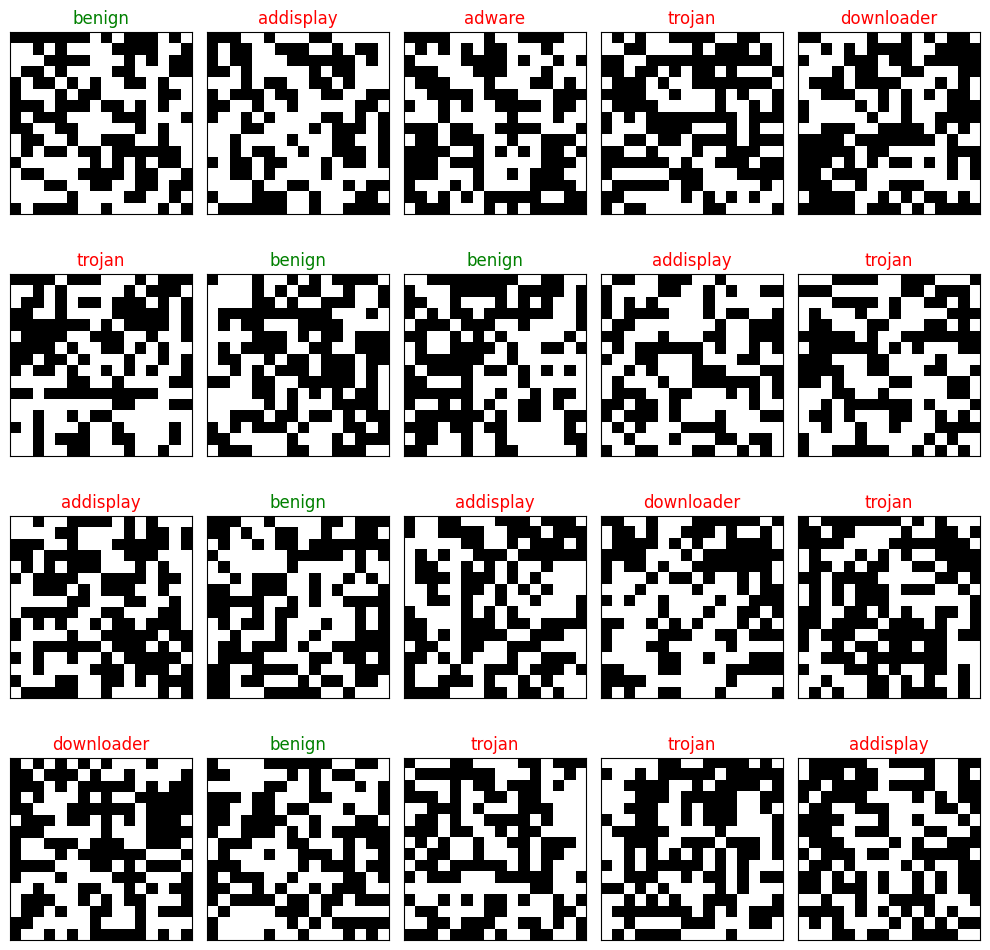

In [10]:
# Set the random seed
np.random.seed(10)
# With all of this in place let's visualize a few samples
# You can adjust the size here
tmp_indicies = np.random.randint(low=0, high=len(X), size=(20))

plt.figure(figsize=(10, 10))
for idx, value in enumerate(tmp_indicies):
    # Adjust the 4,5 here, if you changed the size above
    # Ensure it is a multiple of size
    ax = plt.subplot(4,5,idx+1)
    ax.set_title(label=malware_labels[y[value.item() ].item()  ], color='green' if y[value.item() ].item() == 2 else 'red' )
    ax.imshow(X=X[value].reshape(16, -1), cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

### Step 3:  
Load the classifier and put it in eval mode  

In [11]:
# Let's load the model we will target
# Now that we know this works. Time to move on.
loaded_pgd_model = torch.jit.load(f=r'../data/mal_net_tiny_malware_clf.jit', map_location=device)
loaded_pgd_model.eval()


RecursiveScriptModule(
  original_name=MalClassifier
  (conv_layers): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=Conv2d)
    (4): RecursiveScriptModule(original_name=BatchNorm2d)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=Conv2d)
    (7): RecursiveScriptModule(original_name=BatchNorm2d)
    (8): RecursiveScriptModule(original_name=ReLU)
  )
  (global_avg_pool): RecursiveScriptModule(original_name=AdaptiveAvgPool2d)
  (classifier): RecursiveScriptModule(original_name=Conv2d)
)

### Step 4:   
Setup the PGD attack manually   

In [12]:
#Setup the Progected Gradient attack
def pgd_attack(model=None, X=None, label=None, eps=None, alpha=None, n_iterations=1):

    # Move X and y to the device
    X = X.to(device)

    # Create the adversarial example from a random uniform distribution
    # THe values should fall between -eps and eps 
    adversarial_X = X + torch.empty_like(input=X).uniform_(-eps, to=eps).to(device=device)

    # Clip the values to between 0 and 1
    adversarial_X = torch.clamp(input=adversarial_X, min=0, max=1).detach().requires_grad_(True)

    # Create the adversarial example through multiple iterations
    for epoch in range(n_iterations):

        # Make the predictions on the sample
        predictions = model(adversarial_X)

        # Calculate the loss
        loss = F.cross_entropy(input=predictions, target=label.to(device))
        
        # Zero out the gradients
        model.zero_grad(set_to_none=True)

        # perform back propagation  
        loss.backward()

        # Get the gradients for the input
        gradients = adversarial_X.grad.data
        
        # perform the perturbations 
        adversarial_X = adversarial_X + alpha * torch.sign(input=gradients)

        # Clip the perturbations
        perturbations = torch.clamp(input=adversarial_X - X, min=-eps, max=eps)

        # Create the perturbations and clip it between 0 and 1
        adversarial_X = torch.clamp(input=X + perturbations, min=0, max=1).detach()

        adversarial_X.requires_grad_(True)
        
        print(f'Epoch: {epoch + 1} \t Loss: {loss}')

    # Return the perturbations and the adversarial example
    return perturbations, adversarial_X, eps

In [13]:
# Execute the attack
torch.manual_seed(10)
#pgd_attack(model=loaded_pgd_model, X=X, label=y, eps=0.2, alpha=0.2)

### Setup 5:   

In [14]:
# Call the function
perturbations, adversarial_examples, eps = pgd_attack(model=loaded_pgd_model, X=X, label=y, eps=.009, alpha=2, n_iterations=1)

Epoch: 1 	 Loss: 0.28060147166252136


In [15]:
# Make predictions on the perturb adversarial examples
adversarial_predictions = loaded_pgd_model(adversarial_examples).argmax(dim=-1)
adversarial_accuracy = (adversarial_predictions == y.to(device)).sum() / len(y.to(device))
print(f'Adversarial accuracy is: {adversarial_accuracy:.4f}')

# Get the accuracy on the real samples
real_predictions = loaded_pgd_model(X.to(device)).argmax(dim=-1)
real_accuracy = (real_predictions == y.to(device)).sum() / len(y.to(device))
print(f'Real accuracy is: {real_accuracy:.4f}')


Adversarial accuracy is: 0.7050
Real accuracy is: 0.8700


Try different numbers for the eps and alpha parameters to see how the model performs.    

In [16]:
# Get the attack success rate ...
# How many labels were we able to flip from the original predictions  
(adversarial_predictions != real_predictions).sum()/adversarial_predictions.size(dim=0)

tensor(0.1650, device='cuda:0')

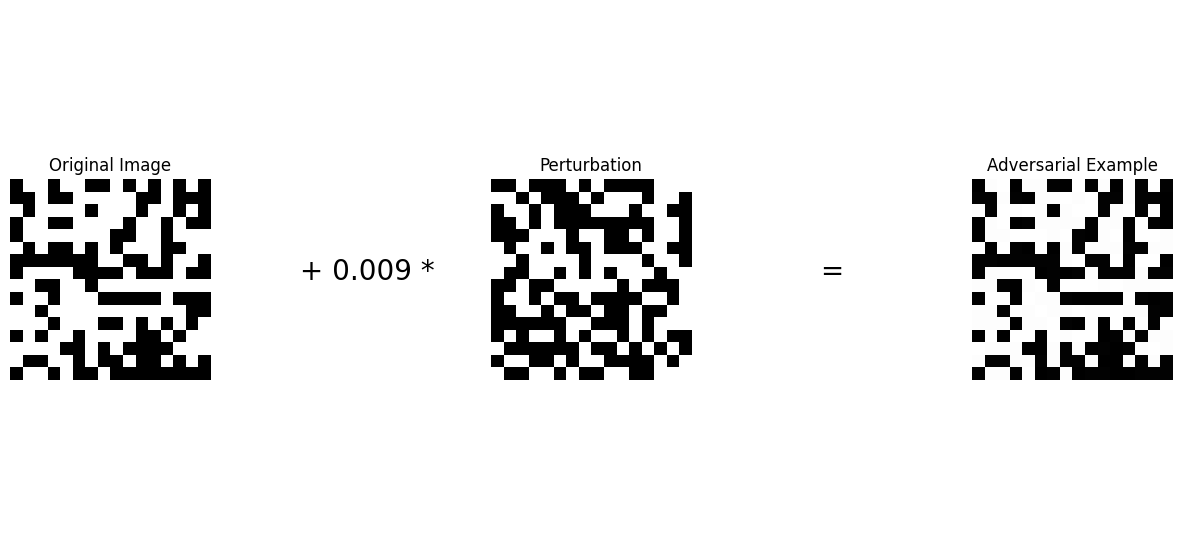

In [17]:
# We can now go ahead and plot the original image and the adversarial example
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,5,1)

# Detach is called because we calculated gradients
# By detaching we are no removing the need to backpropagate
ax.imshow(X[0].detach().squeeze(dim=0).squeeze(dim=0), cmap='gray')
ax.set_axis_off()
ax.set_title(label='Original Image')

# Add the text
ax = fig.add_subplot(1,5,2)
ax.text(x=.2, y=.5, s=f' + {eps} * ', fontdict={'size' : 20 })
ax.set_axis_off()

# The perturbations are the gradients
ax = fig.add_subplot(1,5,3)
ax.imshow(perturbations[0].detach().squeeze(dim=0).squeeze(dim=0).cpu(), cmap='gray')
ax.set_axis_off()
ax.set_title(label='Perturbation')

# Add the text
ax = fig.add_subplot(1,5,4)
ax.text(x=.4, y=.5, s=f' = ', fontdict={'size' : 20 })
ax.set_axis_off()

ax = fig.add_subplot(1,5,5)
# Detach is called because we calculated gradients
# By detaching we are no removing the need to backpropagate
ax.imshow(adversarial_examples[0].detach().cpu().numpy().squeeze(), cmap='gray')
ax.set_axis_off()
ax.set_title(label='Adversarial Example');

### Lab Takeaways:  
- We setup our own Projected Gradient Descent    
- We should have a solid understanding of what Projected Gradient Descent is   